# Project Overview

### In this project I will explore the following dataset:
### *Telco Customer Churn*, BlastChar, 2017
### https://www.kaggle.com/datasets/blastchar/telco-customer-churn


### This is a sample dataset from IBM. It contains customer data from a phone and internet company for over 7000 customers.


### My project focus is to analyze the factors that contribute to customer churn. Customer churn in this context, refers to customers who have left the company in the last month.  

### I plan to create visualizations to understand customer churn and what variables contribute to it, in this dataset. Also, I will prototype machine learning models to devlop a high performing model to predict whether a customer has churned or not.

# Imports:

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")

# Data Preparation

## Data import and cleaning:

In [2]:
# Load in data
full_data = pd.read_csv('customer_churn_data.csv')
# Count nulls
print(full_data.isnull().sum())

# Get rid of ' ' value(s) in TotalCharges
clean_data = full_data[full_data['TotalCharges'] != ' ']

# Drop customer ID column
clean_data = clean_data.drop(columns=['customerID'])

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### Above, I checked for the prescence of any null values. As expected, since this is a sample dataset, there are no null values. However, in the TotalCharges column, which tracks a customer's total charges to their account, contains empty string values. So, I got rid of the rows with the string ' '.

### Also, I dropped the customerID column, since it will not be relevant to my future analyses.

## Get rid of numeric outliers:

In [3]:
# Ensure continous variables are of type float
clean_data[['tenure', 'MonthlyCharges', 'TotalCharges']] = clean_data[['tenure', 'MonthlyCharges', 'TotalCharges']].astype(float)

# Create function to eliminate rows with continous outliers
def outlier_zscoreMethod(dataset, variables, threshold):
    # Make copy of original data
    filtered_dataset = dataset.copy()
    for variable in variables:
        # Calculate z scores for current variable
        z_scores = stats.zscore(filtered_dataset[variable])
        # Create mask that will be used to filter outliers out
        outlier_mask = abs(z_scores) > threshold
        # Apply mask
        filtered_dataset = filtered_dataset[~outlier_mask]
    return filtered_dataset
'''
This function gets rid of outliers in a dataframe(only for continous variables) using the z-score method.

Parameters
----------
dataset: 2D Pandas dataframe
A dataset in df form.

variables: list of string elements
Column names of a dataframe which are quantitative variables.

threshold: float
Number representing how many standard deviations away an observation has to be from the mean for it to be considered an outlier.

Returns
-------
filtered_dataset: 2D Pandas dataframe
New dataset, which no longer contains rows with outliers.
'''

# List of continous variables
continous_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
# Call function to get reid of outliers in continous variables
clean_data = outlier_zscoreMethod(clean_data, continous_features, 3.0)
# No outliers were removed

### Here, I created a function to get rid of outliers in the dataset. This function applies the z-score method. Using the function, I tried to eliminate continous values greater than 3 z-scores. No values exceeded this threshold, so data was not removed.

## Feature engineering:

In [4]:
# Get dummies for categorical variables
data = pd.get_dummies(clean_data, columns=['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'], drop_first=True)

# Convert categorical variables to int data type
data = data.apply(lambda x: x.astype(int) if x.name not in continous_features else x)

# Drop redundant features
data = data.drop(columns=['MultipleLines_No phone service', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service'])

### Above, I converted all categorical variables to dummy variables- as int data types. I also dropped redundant binary features.

# Exploratory Data Analysis

### In this section, I will make some visualizations to help understand customer churn in this dataset- its frequency, and what factors contribute to it.

### Below are a couple of functions for future plotting:

In [5]:
def bar_plot_average(dataset, continuous_var_name, title, y_axis_label):
    # Group data by churn and then calculate average of continuous variable 
    means = dataset.groupby('Churn_Yes')[continuous_var_name].mean()

    # Plot bar plot
    means.plot(kind='bar', color=['lightgreen', 'purple'])

    # Add labels and title
    plt.xlabel('Churn Status')
    plt.ylabel(y_axis_label)
    plt.title(title)

    # Customize x-axis tick labels
    plt.xticks(ticks=[0, 1], labels=['Stayed', 'Churned'], rotation=0)

    # Show the plot
    plt.show()
'''
This function creates a bar plot, where the x-axis is churn status, and the y-axis is the average of a continous variable.

Parameters
----------
dataset: 2D Pandas dataframe
A dataset in df form.

continuous_var_name: string
Column name of dataframe which is a continuous variable(variable on y-axis).

title: string
Title of the plot.

y-axis_label: string
Label of the y-axis of the plot.

Result
-------
A bar plot created by matplotlib.
'''

'\nThis function creates a bar plot, where the x-axis is churn status, and the y-axis is the average of a continous variable.\n\nParameters\n----------\ndataset: 2D Pandas dataframe\nA dataset in df form.\n\ncontinuous_var_name: string\nColumn name of dataframe which is a continuous variable(variable on y-axis).\n\ntitle: string\nTitle of the plot.\n\ny-axis_label: string\nLabel of the y-axis of the plot.\n\nResult\n-------\nA bar plot created by matplotlib.\n'

In [6]:
def bar_plot_percentage(dataset, binary_var_name, title, y_axis_label):
    # Calculate percent of binary variable for each class
    percent_churned_yes = (dataset[dataset['Churn_Yes'] == 1][binary_var_name].mean())*100

    # Calculate percent of customers who do not churn(stay)
    percent_churned_no = 100 - percent_churned_yes

    # Plot
    plt.bar(['Stayed', 'Churned'], [percent_churned_no, percent_churned_yes], color=['skyblue', 'orange'])
    plt.ylabel(y_axis_label)
    plt.title(title)
    plt.show()
'''
This function creates a bar plot, where the x-axis is churn status, and the y-axis is a different binary 
variable(represented as a percentage).

Parameters
----------
dataset: 2D Pandas dataframe
A dataset in df form.

binary_var_name: string
Column name of dataframe which is a binary variable(variable on y-axis).

title: string
Title of the plot.

y-axis_label: string
Label of the y-axis of the plot.

Result
-------
A bar plot created by matplotlib.
'''

'\nThis function creates a bar plot, where the x-axis is churn status, and the y-axis is a different binary \nvariable(represented as a percentage).\n\nParameters\n----------\ndataset: 2D Pandas dataframe\nA dataset in df form.\n\nbinary_var_name: string\nColumn name of dataframe which is a binary variable(variable on y-axis).\n\ntitle: string\nTitle of the plot.\n\ny-axis_label: string\nLabel of the y-axis of the plot.\n\nResult\n-------\nA bar plot created by matplotlib.\n'

### First, I will look at how often customer churn occures:

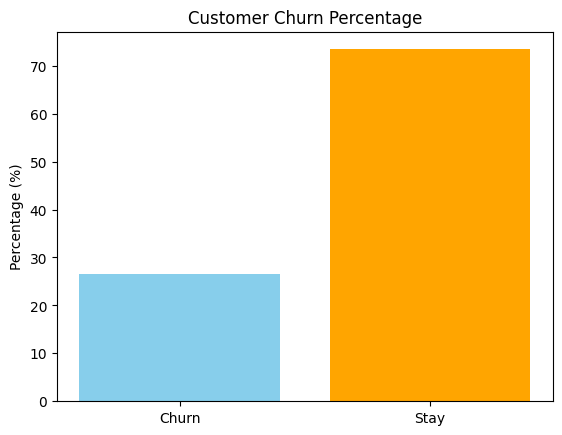

In [7]:
# Calculate percent of customers who churn
percent_churn = (np.mean(data['Churn_Yes']))*100

# Calculate percent of customers who do not churn(stay)
percent_stay = 100 - percent_churn

# Plot
plt.bar(['Churn', 'Stay'], [percent_churn, percent_stay], color=['skyblue', 'orange'])
plt.ylabel('Percentage (%)')
plt.title('Customer Churn Percentage')
plt.show()

### We see that about 26 percent of customers churn.

### In order to predict whether a customer has churned, it is important to identify variables in this dataset that are good predictors. To do this, I will fit a basic decision tree on all the predictor variables to predict churn. Then, I will find the feature importances for each variable. These are calculated by ranking each variable in terms of how well they contributed to splitting nodes in the tree, in order to get closer to predicting churn:

In [8]:
# Get independent variables
X = data.drop(columns=['Churn_Yes'])

# Get dependent variable
y = data['Churn_Yes']

# Initialize dt classifier
dt = DecisionTreeClassifier(random_state=10)
# Fit model
dt.fit(X, y)

# Calculate the importance level of each feature in X_data1 for the dt clasifier
feature_ranking = dt.feature_importances_

# Create dataframe of feature importance with the corresponding features
feature_ranking_df = pd.DataFrame({'Feature': X.columns, 'Importance_Level': feature_ranking})
#print(featureImportance_df)

# Sort the df in a descending order
feature_ranking_df_sorted = feature_ranking_df.sort_values(by='Importance_Level', ascending=False)

# Print the sorted df
print(feature_ranking_df_sorted) # Income is the most important feature followed by recency.

                                  Feature  Importance_Level
0                                  tenure          0.216307
2                            TotalCharges          0.214362
1                          MonthlyCharges          0.174310
9             InternetService_Fiber optic          0.107369
21         PaymentMethod_Electronic check          0.028353
3                             gender_Male          0.024910
6                          Dependents_Yes          0.020734
5                             Partner_Yes          0.020334
4                         SeniorCitizen_1          0.018712
8                       MultipleLines_Yes          0.018122
19                   PaperlessBilling_Yes          0.015923
11                     OnlineSecurity_Yes          0.015307
13                   DeviceProtection_Yes          0.015057
14                        TechSupport_Yes          0.015048
15                        StreamingTV_Yes          0.013259
12                       OnlineBackup_Ye

### From the above variable importance ranking, the following variables are most important to predicting customer churn: Tenure, total and monthly charges, whether the customer uses fiber optic and/or electronic checks, and whether the customer is male.

### Let's now take a look more closely on the relationships between these variables and customer churn:

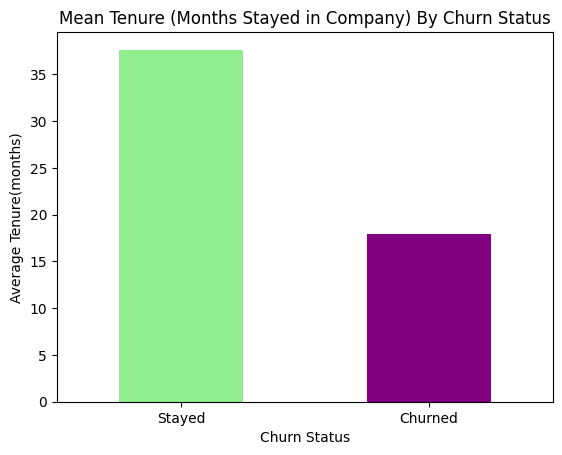

In [9]:
bar_plot_average(dataset=data, continuous_var_name='tenure', title='Mean Tenure (Months Stayed in Company) By Churn Status', y_axis_label='Average Tenure(months)')

### In the above plot, we see the average tenure for customers who did not churn is about 37 months(about 3.08 years), while the average tenure for customers who did churn is about 17 months(about 1.42 years). This is a significant difference. 

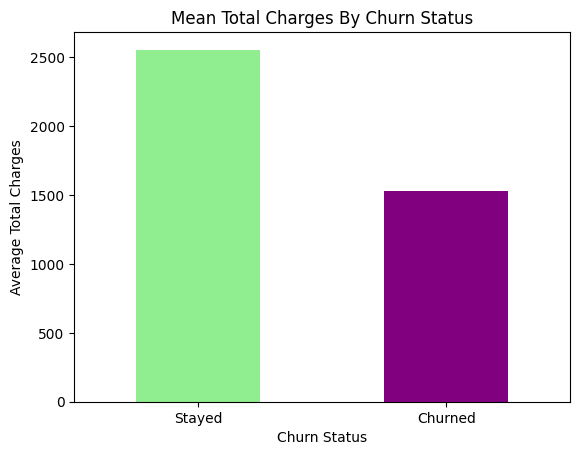

In [10]:
bar_plot_average(dataset=data, continuous_var_name='TotalCharges', title='Mean Total Charges By Churn Status', y_axis_label='Average Total Charges')

### As seen above, the average total charges for customers who have churned is about $1000 less than those who have stayed in the company.

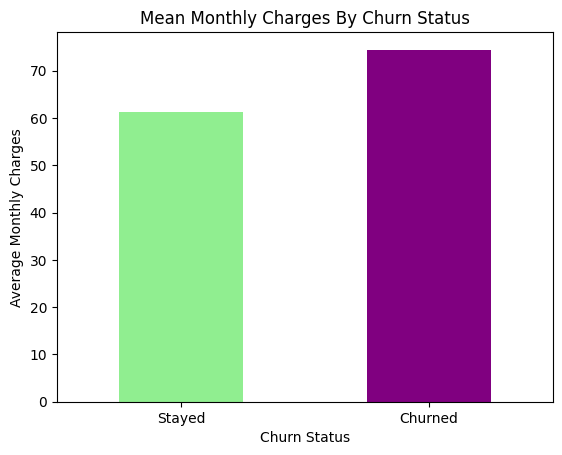

In [11]:
bar_plot_average(dataset=data, continuous_var_name='MonthlyCharges', title='Mean Monthly Charges By Churn Status', y_axis_label='Average Monthly Charges')

### Interestingly, customers who have churned have higher average monthly charges- about $73. And customers who have not churned have an average of about $61. 

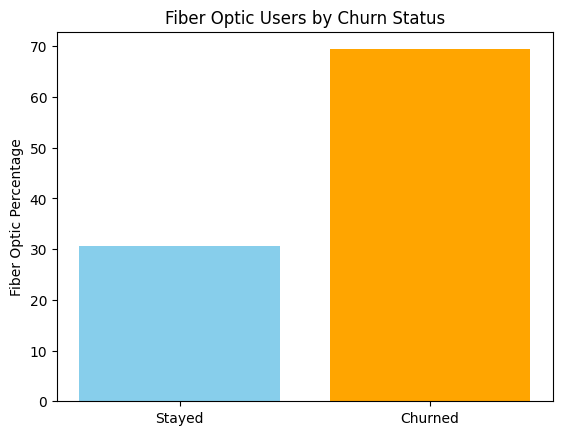

In [12]:
bar_plot_percentage(dataset=data, binary_var_name='InternetService_Fiber optic', title='Fiber Optic Users by Churn Status', y_axis_label='Fiber Optic Percentage')

### We see here that a large majority of customers who have churned use fibor optic as their internet service providor(almost 70%)- a little over double the customers who have not churned.

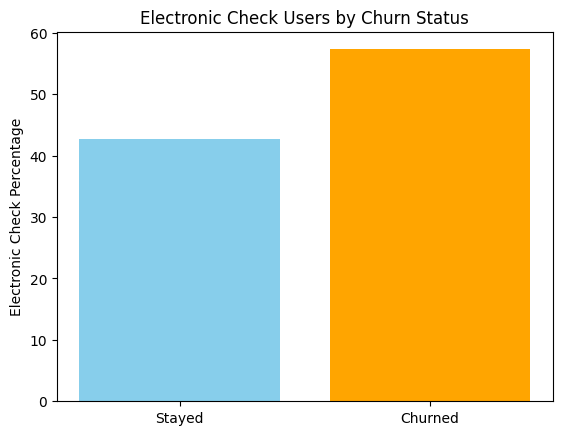

In [13]:
bar_plot_percentage(dataset=data, binary_var_name='PaymentMethod_Electronic check', title='Electronic Check Users by Churn Status', y_axis_label='Electronic Check Percentage')

### Here, we see that a majority of churned customers use electronic checks(about 58%) as opposed to customers who did not churn(about 42%)

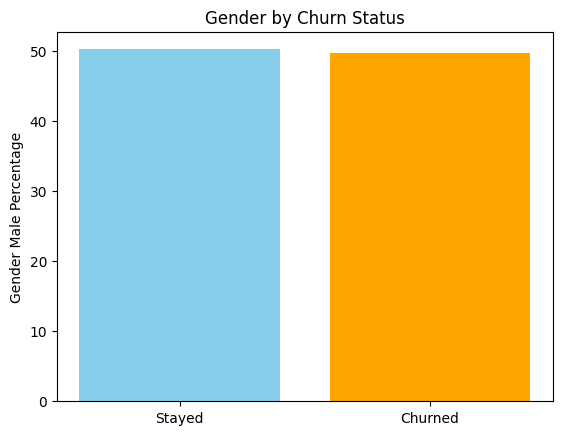

In [14]:
bar_plot_percentage(dataset=data, binary_var_name='gender_Male', title='Gender by Churn Status', y_axis_label='Gender Male Percentage')

### Lastly, we see the gender statistics for customers. Of the customers who did not churn, a little over 50% of them are male. Of the customers who did churn, about 50% of them are male. 

## Machine Learning Modeling

### Since the goal is to accurately predict whether a customer has churned or not, this problem falls under classification. Since the churn variable is binary(and therefore categorical), I will prototype a few classification models to classify churn- logistic regression, random forest, and boosting.

### First I will make a function to calculate cross validated error of these models. This will help to determine the most accurate model, on average:

In [15]:
def calculate_cv_accuracy(model, X, y, cv=5):
    # Calculate cv accuracies
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')  
    return scores.mean()
'''
This function calculates cross validated error of some scikit-learn models

Parameters
----------
model: object
A scikit-learn model object

X: 2D Pandas dataframe
Predictor variables for model training.

y: 1D Pandas Series
Response variable for model training.

Returns
-------
Scores.mean(): float
Average accuracy from cross validation.
'''


'\nThis function calculates cross validated error of some scikit-learn models\n\nParameters\n----------\nmodel: object\nA scikit-learn model object\n\nX: 2D Pandas dataframe\nPredictor variables for model training.\n\ny: 1D Pandas Series\nResponse variable for model training.\n\nReturns\n-------\nScores.mean(): float\nAverage accuracy from cross validation.\n'

### To start I will use Logistic Regression. With each model type, I will use three sets of the dataset for X- The first is the entire X matrix, which contains of the predictors. The next subset, X_2 will contain the top six variables from the feature importance ranking. Lastly, I will use X_3, which contains the top 4 variables, since there is a big doproff in feature importance after this.

In [16]:
# LOGISTIC REGRESSION

# Scale numeric data for Logistic Regression
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[continous_features] = scaler.fit_transform(X[continous_features])

# Get X subsets for models(scaled)
X_2_scaled = X_scaled[['tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'gender_Male']]
X_3_scaled = X_2_scaled.drop(columns=['PaymentMethod_Electronic check', 'gender_Male'])
# Create list of dfs
X_scaled_list = [X_scaled, X_2_scaled, X_3_scaled]

# Get X subsets for models(not scaled)
X_2 = X[['tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'gender_Male']]
X_3 = X_2.drop(columns=['PaymentMethod_Electronic check', 'gender_Male'])
# Create list of dfs
X_list = [pd.DataFrame(X), pd.DataFrame(X_2), pd.DataFrame(X_3)]

# Initialize Logistic Regression model
lr = LogisticRegression(random_state=10)

# Calculate cross-validated accuracy for models
for x in X_scaled_list:
    print(f"Cross-validated Accuracy: {calculate_cv_accuracy(lr, x, y)}")

Cross-validated Accuracy: 0.8033264888724434
Cross-validated Accuracy: 0.7937978265550928
Cross-validated Accuracy: 0.7885361851583376


### Of all the X matrices used, the one with all the predictors had the highest cross validated accuracy for logistic regression(when predicting customer churn)- 80.33%. This means that the best logistic regression model here is, on average, 80.33% accurate when predicting unseen data.The less predictors I included, the lower the cross validated accuracy.

### Next, is Random Forest, and Gradient Boosting. For these models, I will use the first subset- all of the predictors.

### For random forest, I will use the grid search method to find the optimal number trees, max depth, and max_features:

In [17]:
# Initialize random forest model
rf = RandomForestClassifier(random_state=10)

# Create prameter grid for rf
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', None]
}

# Perform GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_rf.fit(X, y)

# Find best model
best_rf = grid_search_rf.best_estimator_

# Print the best hyperparameters found by GridSearchCV
print(f"Best hyperparameters: {grid_search_rf.best_params_}")

# Obtain best CV accuracy
cv_accuracy_rf = grid_search_rf.best_score_
print(f"Best cross-validation accuracy: {cv_accuracy_rf}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...max_depth=10, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=10, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=10, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END ...max_depth=10, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END ...max_depth=10, max_features=auto, n_estimators=50; total time=   0.0s
[CV] END ..max_depth=10, max_features=auto, n_estimators=100; total time=   0.0s
[CV] END ..max_depth=10, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ..max_depth=10, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ..max_depth=10, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ..max_depth=10, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ..max_depth=10, max_features=auto, n_estimators=200; total time=   0.0s
[CV] END ...max_depth=10, max_features=auto, n_

### After finding optimal parameters, the cross-validated accuracy for predicting customer churn is about 80.49%. This is slightly less than the accuracy of logistic regression. This means that this specific random forest model is, on average, 80.49% accurate when predicting unseen data. 

### Lastly, for the gradiant boosting tree model I will do a similar grid search procedure, except, instead of optimizing max_features, I will optimize learning rate.

In [18]:
# Create parameter grid for GradientBoostingClassifier
param_grid_gbc = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

# Initialize the GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=10)

# Perform GridSearchCV with cross-validation on the dataset
grid_search_gbc = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_gbc.fit(X, y)

# Retrieve the best model 
best_gbc = grid_search_gbc.best_estimator_

# Print the best hyperparameters found by GridSearchCV
print(f"Best hyperparameters: {grid_search_gbc.best_params_}")

# Obtain best CV accuracy
cv_accuracy_gbc = grid_search_gbc.best_score_
print(f"Best cross-validation accuracy: {cv_accuracy_gbc}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.5s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.6s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.6s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.6s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.0s
[CV] END ...learning_rate=0.01, max_depth=4, n_estimators=50; total time=   0.7s
[CV] END ...learning_rate=0.01, max_depth=4, n_

### After finding optimal parameters, the cross-validated accuracy for predicting customer churn is about 80.46%. This is slightly less than the accuracy of the random forest model, but slighly better than the logistic regression model. This means that this specific boosting model is, on average, 80.46% accurate when predicting churn on unseen data.

## Conclusion:

### Overall, the random forest model had the highest accuracy for predicting customer churn on unseen data- 80.49%. The gradient boosting model came in a close second- 80.46%. Logistic regression had the lowest average accuracy- 80.33%. 

### These models have many practical applications. They can be used to predict whether or not a customer has a high chance of leaving the company. Marketing campaigns and promotions can be targeted to those who have already churned, or are at a high risk of churn.